In [12]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import Masking
from keras.optimizers import RMSprop
from keras import backend as k
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt


"""
    Discrete log-likelihood for Weibull hazard function on censored survival data
    y_true is a (samples, 2) tensor containing time-to-event (y), and an event indicator (u)
    ab_pred is a (samples, 2) tensor containing predicted Weibull alpha (a) and beta (b) parameters
    For math, see https://ragulpr.github.io/assets/draft_master_thesis_martinsson_egil_wtte_rnn_2016.pdf (Page 35)
"""
def weibull_loglik_discrete(y_true, ab_pred, name=None):
    y_ = y_true[:, 0]
    u_ = y_true[:, 1]
    a_ = ab_pred[:, 0]
    b_ = ab_pred[:, 1]

    hazard0 = k.pow((y_ + 1e-35) / a_, b_)
    hazard1 = k.pow((y_ + 1) / a_, b_)

    return -1 * k.mean(u_ * k.log(k.exp(hazard1 - hazard0) - 1.0) - hazard1)

"""
    Not used for this model, but included in case somebody needs it
    For math, see https://ragulpr.github.io/assets/draft_master_thesis_martinsson_egil_wtte_rnn_2016.pdf (Page 35)
"""
def weibull_loglik_continuous(y_true, ab_pred, name=None):
    y_ = y_true[:, 0]
    u_ = y_true[:, 1]
    a_ = ab_pred[:, 0]
    b_ = ab_pred[:, 1]

    ya = (y_ + 1e-35) / a_
    return -1 * k.mean(u_ * (k.log(b_) + b_ * k.log(ya)) - k.pow(ya, b_))


"""
    Custom Keras activation function, outputs alpha neuron using exponentiation and beta using softplus
"""
def activate(ab):
    a = k.exp(ab[:, 0])
    b = k.softplus(ab[:, 1])

    a = k.reshape(a, (k.shape(a)[0], 1))
    b = k.reshape(b, (k.shape(b)[0], 1))

    return k.concatenate((a, b), axis=1)


"""
    Load and parse engine data files into:
       - an (engine/day, observed history, sensor readings) x tensor, where observed history is 100 days, zero-padded
         for days that don't have a full 100 days of observed history (e.g., first observed day for an engine)
       - an (engine/day, 2) tensor containing time-to-event and 1 (since all engines failed)

    There are probably MUCH better ways of doing this, but I don't use Numpy that much, and the data parsing isn't the
    point of this demo anyway.
"""
def load_file(name):
    with open(name, 'r') as file:
        return np.loadtxt(file, delimiter=',')

np.set_printoptions(suppress=True, threshold=10000)

# train = load_file('train.csv')
# test_x = load_file('test_x.csv')
# test_y = load_file('test_y.csv')
#
# # Combine the X values to normalize them, then split them back out
# all_x = np.concatenate((train[:, 2:26], test_x[:, 2:26]))
# all_x = normalize(all_x, axis=0)
#
# train[:, 2:26] = all_x[0:train.shape[0], :]
# test_x[:, 2:26] = all_x[train.shape[0]:, :]
#
# # Make engine numbers and days zero-indexed, for everybody's sanity
# train[:, 0:2] -= 1
# test_x[:, 0:2] -= 1
#
# # Configurable observation look-back period for each engine/day
# max_time = 100
#
# def build_data(engine, time, x, max_time, is_test):
#     # y[0] will be days remaining, y[1] will be event indicator, always 1 for this data
#     out_y = np.empty((0, 2), dtype=np.float32)
#
#     # A full history of sensor readings to date for each x
#     out_x = np.empty((0, max_time, 24), dtype=np.float32)
#
#     for i in range(100):
#         print("Engine: " + str(i))
#         # When did the engine fail? (Last day + 1 for train data, irrelevant for test.)
#         max_engine_time = int(np.max(time[engine == i])) + 1
#
#         if is_test:
#             start = max_engine_time - 1
#         else:
#             start = 0
#
#         this_x = np.empty((0, max_time, 24), dtype=np.float32)
#
#         for j in range(start, max_engine_time):
#             engine_x = x[engine == i]
#
#             out_y = np.append(out_y, np.array((max_engine_time - j, 1), ndmin=2), axis=0)
#
#             xtemp = np.zeros((1, max_time, 24))
#             xtemp[:, max_time-min(j, 99)-1:max_time, :] = engine_x[max(0, j-max_time+1):j+1, :]
#             this_x = np.concatenate((this_x, xtemp))
#
#         out_x = np.concatenate((out_x, this_x))
#
#     return out_x, out_y
#
#
# train_x, train_y = build_data(train[:, 0], train[:, 1], train[:, 2:26], max_time, False)
# test_x = build_data(test_x[:, 0], test_x[:, 1], test_x[:, 2:26], max_time, True)[0]
#
# train_u = np.zeros((100, 1), dtype=np.float32)
# train_u += 1
# test_y = np.append(np.reshape(test_y, (100, 1)), train_u, axis=1)

data_x = load_file('D:/Praca Magisterska/nowe/stddevs/train_x.csv')
data_y = load_file('D:/Praca Magisterska/nowe/stddevs/train_y.csv')
print(data_y.shape)
data_u = np.zeros((data_y.shape[0], 1), dtype=np.float32)
data_u += 1
data_y = np.append(np.reshape(data_y, (data_y.shape[0], 1)), data_u, axis=1)
# print(data_y)

number_of_series = 4

# Configurable observation look-back period for each engine/day
max_time = 100

# y[0] will be days remaining, y[1] will be event indicator, always 1 for this data
out_y = np.empty((0, 2), dtype=np.float32)
# print(out_y.shape)

# A full history of sensor readings to date for each x
out_x = np.empty((0, max_time, 1), dtype=np.float32)

print(data_x.shape)

data_x[:, 2] = normalize(data_x[:, 2].reshape(-1, 1))[:, 0]

for i in range(data_x.shape[0]):
    this_x = np.zeros((1, max_time, 1))
    for b in range(max_time):
        if i-max_time+b+1 < 0:
            this_x[0, b] = 0
        elif data_x[i-max_time+b+1, 0] < data_x[i, 0]:
            this_x[0, b] = 0
        else:
            this_x[0, b] = data_x[i-max_time+b+1, 2]

    out_x = np.concatenate((out_x, this_x))



#print(out_x)
#np.savetxt("D:/Praca Magisterska/nowe/stddevs/x.csv", out_x, delimiter=",")


"""
    Here's the rest of the meat of the demo... actually fitting and training the model.
    We'll also make some test predictions so we can evaluate model performance.
"""

# Start building our model
model = Sequential()

# Mask parts of the lookback period that are all zeros (i.e., unobserved) so they don't skew the model
model.add(Masking(mask_value=0., input_shape=(max_time, 1)))

# LSTM is just a common type of RNN. You could also try anything else (e.g., GRU).
model.add(LSTM(20, input_dim=1))

# We need 2 neurons to output Alpha and Beta parameters for our Weibull distribution
model.add(Dense(2))

# Apply the custom activation function mentioned above
model.add(Activation(activate))

# Use the discrete log-likelihood for Weibull survival data as our loss function
model.compile(loss=weibull_loglik_discrete, optimizer=RMSprop(lr=.001))

# Fit!
model.fit(out_x, data_y, epochs=250, batch_size=100, verbose=2, validation_data=(out_x, data_y))


(936,)
(936, 3)


c:\python36\lib\site-packages\ipykernel_launcher.py:184: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
c:\python36\lib\site-packages\ipykernel_launcher.py:184: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(20, input_shape=(None, 1))`


Train on 936 samples, validate on 936 samples
Epoch 1/250
 - 3s - loss: 6.6819 - val_loss: 5.8283
Epoch 2/250
 - 1s - loss: 5.5589 - val_loss: 5.2772
Epoch 3/250
 - 1s - loss: 5.1755 - val_loss: 5.0763
Epoch 4/250
 - 1s - loss: 5.0300 - val_loss: 4.9708
Epoch 5/250
 - 1s - loss: 4.9266 - val_loss: 4.8582
Epoch 6/250
 - 2s - loss: 4.7961 - val_loss: 4.7009
Epoch 7/250
 - 2s - loss: 4.6164 - val_loss: 4.4839
Epoch 8/250
 - 2s - loss: 4.3705 - val_loss: 4.2045
Epoch 9/250
 - 2s - loss: 4.1119 - val_loss: 4.0108
Epoch 10/250
 - 2s - loss: 3.9738 - val_loss: 3.9334
Epoch 11/250
 - 2s - loss: 3.9183 - val_loss: 3.8981
Epoch 12/250
 - 2s - loss: 3.8882 - val_loss: 3.8747
Epoch 13/250
 - 2s - loss: 3.8683 - val_loss: 3.8586
Epoch 14/250
 - 2s - loss: 3.8490 - val_loss: 3.8538
Epoch 15/250
 - 2s - loss: 3.8319 - val_loss: 3.8254
Epoch 16/250
 - 2s - loss: 3.7917 - val_loss: 3.7586
Epoch 17/250
 - 2s - loss: 3.7609 - val_loss: 3.7343
Epoch 18/250
 - 2s - loss: 3.7239 - val_loss: 3.7314
Epoch 19/

Epoch 154/250
 - 2s - loss: 3.3744 - val_loss: 3.4586
Epoch 155/250
 - 2s - loss: 3.3960 - val_loss: 3.3798
Epoch 156/250
 - 2s - loss: 3.3916 - val_loss: 3.4038
Epoch 157/250
 - 2s - loss: 3.4031 - val_loss: 3.3980
Epoch 158/250
 - 2s - loss: 3.3822 - val_loss: 3.3655
Epoch 159/250
 - 2s - loss: 3.3913 - val_loss: 3.4010
Epoch 160/250
 - 2s - loss: 3.3813 - val_loss: 3.3674
Epoch 161/250
 - 2s - loss: 3.3770 - val_loss: 3.3785
Epoch 162/250
 - 3s - loss: 3.4212 - val_loss: 3.3907
Epoch 163/250
 - 2s - loss: 3.3813 - val_loss: 3.3664
Epoch 164/250
 - 2s - loss: 3.3820 - val_loss: 3.3730
Epoch 165/250
 - 2s - loss: 3.3882 - val_loss: 3.3832
Epoch 166/250
 - 2s - loss: 3.3780 - val_loss: 3.3863
Epoch 167/250
 - 2s - loss: 3.3807 - val_loss: 3.4656
Epoch 168/250
 - 2s - loss: 3.3888 - val_loss: 3.4514
Epoch 169/250
 - 2s - loss: 3.3973 - val_loss: 3.3724
Epoch 170/250
 - 2s - loss: 3.3686 - val_loss: 3.3774
Epoch 171/250
 - 2s - loss: 3.4282 - val_loss: 3.4016
Epoch 172/250
 - 2s - loss: 

[ 5.870113 20.299845 32.883324 36.32113  36.364338 36.126583 36.001682
 36.016132 36.097233 36.17975  36.23255  36.21458  36.14092  36.034798
 35.905285 35.75993  35.60592  35.450054 35.29832  35.1557   35.02619
 34.91272  34.81735  34.741352 34.685307 34.649155 34.584103 34.521797
 34.47696  34.4497   34.43853  34.44142  34.44684  34.45349  34.46425
 34.475853 34.48209  34.47489  34.4449   34.38246  34.27898  34.129013
 33.90542  33.63497  33.342236 33.05889  32.824406 32.675354 32.629044
 32.6703   32.75186  32.810993 32.791092 32.655254 32.388294 31.992647
 31.483147 30.882866 30.219498 29.521856 28.816685 28.126371 27.467705
 26.85181  26.284767 25.768606 25.302402 24.883205 24.50681  24.168474
 23.86345  23.587406 23.3367   23.10842  22.900343 22.710688 22.537798
 22.379593 22.232754 22.091362 21.945023 21.776379 21.559078 21.257565
 20.831764 20.248877 19.500916 18.61873  17.669466 16.734022 15.87889
 15.140656 14.527723 14.030833 13.633438 13.318058 13.06916  12.8739
 12.722025 

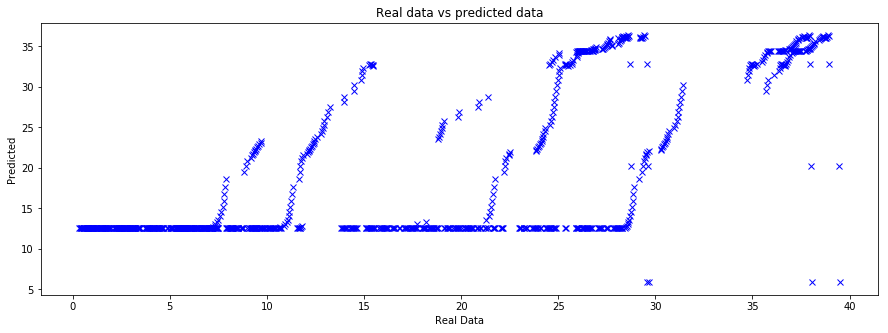

In [13]:
# Make some predictions and put them alongside the real TTE and event indicator values
test_predict = model.predict(out_x)
print("=========================")
print(test_predict[:, 0])
test_predict = np.resize(test_predict, (data_x.shape[0], 2))
test_result = np.concatenate((data_y, test_predict))
print("=========================")
print(test_result[:, 0])



fig, ax = plt.subplots()
ax.set_title('Real data vs predicted data')
ax.plot(data_y[:, 0], test_predict[:, 0], 'bx')
#
# for calib_timestamp in calib_timestamps:
#     ax.plot([calib_timestamp, calib_timestamp], [min(mean_sensor), max(mean_sensor)], 'r', label='Calibrations')
#
# plt.xticks(rotation=25)
plt.rcParams['figure.figsize'] = [15, 5]
# ax.minorticks_on()
# ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
# ax.legend()
plt.xlabel("Real Data")
plt.ylabel("Predicted")
plt.show()

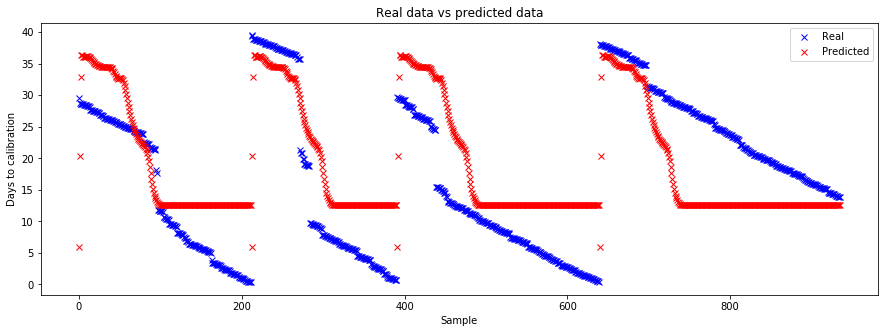

In [14]:
fig, ax = plt.subplots()
ax.set_title('Real data vs predicted data')
ax.plot(data_y[:, 0], 'bx', label='Real')
ax.plot(test_predict[:, 0], 'rx', label='Predicted')

plt.rcParams['figure.figsize'] = [15, 5]
plt.xlabel("Sample")
plt.ylabel("Days to calibration")
ax.legend()
plt.show()